# Sentiment Analysis
The process of computationally identifying and categorizing opinions expressed in a piece of text, especially in order to determine whether the writer's attitude towards a particular topic, product, etc. is positive, negative, or neutral. The Orignal sample comes from https://www.kaggle.com/ngyptr/lstm-sentiment-analysis-keras

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#on osx
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

Using TensorFlow backend.


Keep only the necessary columns.

In [2]:
data = pd.read_csv('sentiment_data/Sentiment.csv')
# Keeping only the neccessary columns
data = data[['text','sentiment']]

Next, I am dropping the 'Neutral' sentiments as my goal was to only differentiate positive and negative tweets. After that, I am filtering the tweets so only valid texts and words remain.  Then, I define the number of max features as 2000 and use Tokenizer to vectorize and convert text into Sequences so the Network can deal with it as input.

In [3]:
data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000

#Tokenizer is a built in Keras tool to break down large group of documents into
# an easily usable format. In particular, it gives
# word_counts: A dictionary of words and their counts.
#word_docs: A dictionary of words and how many documents each appeared in.
#word_index: A dictionary of words and their uniquely assigned integers.
#document_count:An integer count of the total number of documents that were used to fit the Tokenizer.

tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
print(X[500])

4472
16986
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0   44   58   36   52 1374    2]


## Build LSTM Network

Next, I compose the LSTM Network. Note that **embed_dim**, **lstm_out**, **batch_size**, **droupout_x** variables are hyperparameters, their values are somehow intuitive, can be and must be played with in order to achieve good results. As we are only interested in positive or negative sentiment, we can have a sigmoid activation function at the last layer [0,1] and a binary crossentropy loss. If we wanted more categories, we would use softmax and categorical cross_entropy.

In [4]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 28, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 28, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 197       
Total params: 510,997
Trainable params: 510,997
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
# make sure that you have the required dependencies
# sudo apt-get install graphviz
!pip install pydot

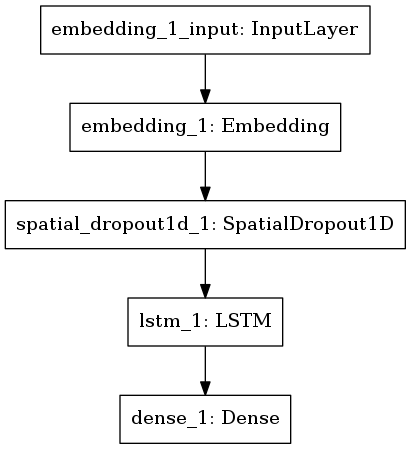

In [7]:
import tensorflow as tf
tf.keras.utils.plot_model(model)

In [8]:
Y=data['sentiment'].astype('category')
Y

1        Positive
3        Positive
4        Positive
5        Positive
6        Negative
8        Negative
9        Negative
10       Negative
11       Positive
12       Negative
14       Positive
15       Negative
16       Negative
17       Negative
18       Negative
19       Negative
20       Positive
21       Negative
22       Negative
24       Negative
25       Negative
26       Negative
27       Negative
28       Negative
29       Negative
30       Negative
31       Negative
34       Negative
35       Negative
36       Negative
           ...   
13839    Negative
13840    Negative
13841    Negative
13843    Negative
13844    Negative
13845    Negative
13847    Positive
13848    Negative
13849    Positive
13850    Negative
13851    Negative
13852    Negative
13853    Negative
13854    Negative
13855    Negative
13856    Negative
13857    Negative
13858    Positive
13859    Positive
13860    Negative
13861    Negative
13862    Positive
13863    Negative
13864    Negative
13865    N

In [9]:
Y=Y.cat.codes
Y

1        1
3        1
4        1
5        1
6        0
8        0
9        0
10       0
11       1
12       0
14       1
15       0
16       0
17       0
18       0
19       0
20       1
21       0
22       0
24       0
25       0
26       0
27       0
28       0
29       0
30       0
31       0
34       0
35       0
36       0
        ..
13839    0
13840    0
13841    0
13843    0
13844    0
13845    0
13847    1
13848    0
13849    1
13850    0
13851    0
13852    0
13853    0
13854    0
13855    0
13856    0
13857    0
13858    1
13859    1
13860    0
13861    0
13862    1
13863    0
13864    0
13865    0
13866    0
13867    1
13868    1
13869    0
13870    1
Length: 10729, dtype: int8

### Prepare train & test dataset 
Try and redress class imbalance by assigning weights

In [10]:
#Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7188, 28) (7188,)
(3541, 28) (3541,)


In [11]:
class_weight={1: 4.0, #redress class imbalance by assigning 4x weight to positive
              0: 1.0}

### Train the network

In [12]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, class_weight=class_weight, verbose = 2)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
 - 7s - loss: 0.9499 - accuracy: 0.6505
Epoch 2/10
 - 7s - loss: 0.6931 - accuracy: 0.7917
Epoch 3/10
 - 7s - loss: 0.6071 - accuracy: 0.8311
Epoch 4/10
 - 7s - loss: 0.5245 - accuracy: 0.8580
Epoch 5/10
 - 7s - loss: 0.4709 - accuracy: 0.8756
Epoch 6/10
 - 6s - loss: 0.4141 - accuracy: 0.8862
Epoch 7/10
 - 7s - loss: 0.3824 - accuracy: 0.8958
Epoch 8/10
 - 7s - loss: 0.3524 - accuracy: 0.9039
Epoch 9/10
 - 7s - loss: 0.3192 - accuracy: 0.9130
Epoch 10/10
 - 7s - loss: 0.3025 - accuracy: 0.9199


Extracting a validation set, and measuring score and accuracy.

In [13]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

2041/2041 [==============================] - 1s 421us/step
score: 0.59
acc: 0.79


In [14]:
Y_validate.values[0]

0

Finally measuring the number of correct guesses.  It is clear that finding negative tweets goes very well for the Network but deciding whether is positive is not really. My educated guess here is that the positive training set is dramatically smaller than the negative, hence the "bad" results for positive tweets.

In [15]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0][0]
    print (result, Y_validate.values[x])
    
    if result>=0.5:
        if Y_validate.values[x]==1:
            pos_correct+=1
            pos_cnt+=1
        else:
            neg_cnt+=1
    else:
        if Y_validate.values[x]==0:
            neg_correct+=1
            neg_cnt+=1
        else:
            pos_cnt+=1

print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

0.006173417 0
0.9806193 0
0.00046944123 0
0.026098922 0
0.0013551563 0
0.020281378 0
0.11567895 0
0.0024498142 1
0.0066609094 0
0.6269026 0
0.03215759 0
0.0017289722 0
0.010615066 0
0.048869446 0
0.97000194 1
0.7740414 0
0.56784457 1
0.00030222477 0
0.9875329 0
0.3919218 0
0.0014986534 0
0.005323952 0
0.97192425 0
0.014659928 1
0.76811343 0
0.032323163 0
0.90986466 1
4.728435e-05 0
0.0019104533 0
0.004781833 0
0.9936685 1
0.03360371 0
0.99428236 0
0.9485945 1
0.80646974 0
0.50238913 0
0.004180378 0
6.5083436e-06 0
0.0008371626 0
0.002289443 1
0.06806903 0
0.015900921 0
0.39918548 0
0.0017289722 0
0.015900921 0
0.15591465 0
0.2402562 0
0.9851526 1
0.0071902066 1
0.000227028 1
0.00035972 0
0.9880156 1
0.2502722 0
0.9866998 1
0.9730828 1
0.15164982 0
0.0038615488 0
0.00056047406 0
0.0002989424 0
0.4165545 0
0.49659923 0
0.6639923 0
0.0005881159 0
0.7304919 0
0.0008371626 0
0.010734939 0
0.69300336 0
0.0028080428 0
0.02906158 0
0.0155179985 0
0.0002544993 0
0.12569793 0
0.99837637 1
0.0830

0.0024012509 0
0.00046944123 0
0.0007758201 0
0.011109177 0
0.28317434 0
0.81767327 1
0.9294936 0
0.96965694 1
0.24711907 1
0.9519131 0
0.018640747 0
0.11509259 0
0.0008061443 0
0.00023624505 0
0.5512592 0
0.0039667534 0
0.09273389 0
0.003365817 0
0.015900921 0
0.93026966 1
0.77271587 1
0.985342 0
5.2265426e-05 0
0.2434957 0
0.38966846 0
0.9850894 0
0.7338536 0
0.083224475 0
0.027379518 0
0.003215899 0
0.5263009 0
0.98240995 1
0.15193604 0
0.00046944123 0
0.988868 1
0.9249785 0
0.9814959 1
0.0022001967 0
0.003365817 0
0.0054795686 1
0.008120645 1
0.9359182 0
0.0011074118 0
0.019002195 0
0.014930659 0
0.0012747451 0
0.07049914 0
0.027379518 0
0.027379518 0
0.99117625 0
0.019903192 0
0.9986319 1
0.98633075 0
0.0006538482 0
0.006284522 0
0.0004878692 0
0.28317434 0
0.024561644 0
0.0002544993 0
0.023527604 0
0.9876143 1
0.94443834 0
0.28333712 0
0.9876352 1
0.14398961 0
0.8452228 1
0.0008035425 0
0.0017427978 0
0.0077919634 0
0.0030783317 0
0.04295659 0
0.00029509075 0
0.99661416 1
0.86315

0.9936685 1
0.9837393 1
0.28317434 0
0.0039487043 0
0.00027626613 0
0.027379518 0
0.0014986534 0
0.16921137 1
0.9936685 1
0.0011907422 0
0.9936685 1
0.61646605 0
0.24602188 0
0.15056495 0
0.0017289722 0
0.15842527 0
0.0041087745 0
0.0023366574 0
0.8802737 0
0.8802737 0
0.6244301 0
0.015900921 0
0.00482278 0
0.8066865 1
0.0007134203 0
0.238152 0
0.0024217512 1
0.05615557 0
0.9965634 1
0.3137756 0
0.53740895 0
0.9965634 1
0.6763989 0
0.0008371626 0
0.00718264 0
0.0028704745 0
0.9796626 1
0.0002544993 0
0.003548897 0
0.0011331016 0
0.0015319576 0
0.006173417 0
0.9986319 1
0.69422925 0
0.39054644 0
0.00021509046 0
0.021747634 0
0.00046944123 0
4.8454476e-05 0
0.9986319 1
0.0008061443 0
0.0015576282 0
0.0024178673 0
0.5033697 1
0.00046944123 0
0.006040596 0
5.0604645e-05 0
0.00028976804 0
0.33549187 1
0.21318465 1
0.0049058013 0
0.0024685746 1
1.9587393e-05 0
0.04947658 0
0.9269504 1
0.81767327 1
0.9723121 1
0.33513042 0
0.9753618 0
0.94512755 1
0.0002427683 0
0.0006075314 0
0.7369644 1
0.0

Please note that the network performs poorly. It's because the training data is very unbalanced (pos: 4472, neg: 16986), you should get more data, use other dataset, use pre-trained model, or weight classes to achieve reliable predictions.

In [16]:
twt = ['Spoke very well']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0][0]
if(sentiment < 0.5):
    print("negative")
else:
    print("positive")

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0 1122  100  222]]
positive


In [17]:
twt = ['What a waste of time']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0][0]
if(sentiment < 0.5):
    print("negative")
else:
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0  49   7   6 108]]
negative
